# Customer Segmentation 

In this notebook, I’ll show how to use k-means clustering to segment customers into distinct groups based on purchasing habits. The dataset is from [instacart-market-basket-analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on kaggle. Since there are several tables, and our target is not about table manipulation, I download the combined data directly from [my kaggle kernel](https://www.kaggle.com/jmy666/customer-segments-with-pca/output).

## Data Description

From the kaggle:
The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

Basicly, each customer has a unique use_id, and might have several orders, which have unique order_id. For each order, there might be different products, belonging to aisles and departments. All products, aisles and departments have unique id and name. Most variables are self-explanatory.

'Reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details. 'order_dow' is the day of week.

## Brief

I use aisles as the criteria of clustering and do not consider the sequence as well as quantity of orders. Therefore, in the table for clustering, each row represents a customer, and each column represents an aisle. The value of each cell is the total number of the specific aisle purchased by that customer. To remove the influence of quantity, I then calculate the proportion of each aisle by dividing the total number of aisles purchased by that customer.

For clustering, I run the models both with and without PCA. The result shows that under low tolerance of variance, PCA can reach similar result and reduce the complexity of models significantly.

Also, I demonstrate how to choose best k (number of clusters) step by step.

## Business Interpretation of Clusters

I understand that only clustering does not create values, and we need to interpret our models. This notebook shows how to gain insights from clusters from different aspects. At first I list top 10 aisles for each cluster and find that they are similar. I realize that this is because some aisles are necessaries of life. Then I remove the influence of necessaries, and list top 10 aisles for each cluster again. The result is really interesting, and we can gain clear insights about different clusters.


## Data Preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns # data visualization

In [3]:
order = pd.read_csv("combined_order.csv")
order.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs


In [4]:
#Since the first column is the index of row, we can delete it
order = order.iloc[:,1:]

In [5]:
order[order["order_id"]==2]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
4304,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,fresh vegetables
4305,2,17794,6,1,Carrots,83,4,202279,prior,3,5,9,8.0,fresh vegetables
35308,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,spices seasonings
37232,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,oils vinegars
39528,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,baking ingredients
42503,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,202279,prior,3,5,9,8.0,doughs gelatins bake mixes
43492,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,202279,prior,3,5,9,8.0,spreads
46242,2,43668,9,0,Classic Blend Cole Slaw,123,4,202279,prior,3,5,9,8.0,packaged vegetables fruits


We can cluster customers at product level, aisle level and even department level. Since there are too many products, I suggest to use aisle or department as the criteria of clustering. In this notebook, I will conduct customer segmentation based on aisles.

In [6]:

cust_prod = pd.crosstab(order['user_id'], order['aisle'])
cust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Scale Data

Some customers might purchase goods for a big family, while others might do that just for themselves. Therefore, different customers may purchase goods in different quantities. To reduce the influence of quantity, we can use the proportion of all items purchased by a customer.

In [7]:
summ = cust_prod.sum(axis = 1)


In [8]:
summ.values

array([11,  5,  9, ...,  4,  8, 16], dtype=int64)

In [9]:
#Let's check whether there is any customer who did not buy anything
(summ == 0).sum()

0

In [10]:
df = (cust_prod.T/summ.values).T

In [11]:
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
13,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,0.000000
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.444444
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.307692
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [12]:
df.shape

(25831, 134)

In [22]:
# let's sample the data to run clusering faster
df_s = df.sample(10000)

## Clustering

In [49]:
#run the clustering
from sklearn.cluster import KMeans
data = df_s
km = KMeans(n_clusters = 5, init= 'k-means++',max_iter = 300, random_state = 1, n_init = 10, tol = 1e-04)
y_km = km.fit_predict(data)

In [51]:
from sklearn import metrics
metrics.silhouette_score(data, y_km, metric='euclidean')

0.051442964647826876

In [44]:
#use elbow method to find the best n_clusters
distortions = []
silhouette_score = []
data = df_s
for i in range(2,31):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=1)
    label = km.fit_predict(data)
    distortions.append(km.inertia_)
    sc = metrics.silhouette_score(data, label)
    silhouette_score.append(sc)
    


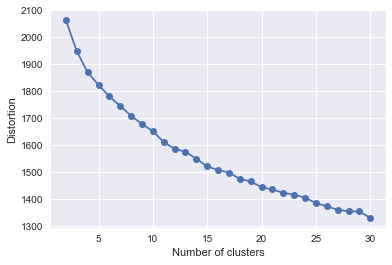

In [47]:
plt.plot(range(2,31), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

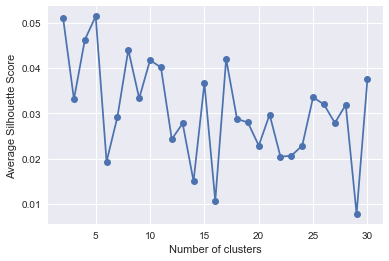

In [48]:
plt.plot(range(2,31), silhouette_score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

From above picture, we can see that 5 is good number of clusters. Then let's see the details of Silhouette Score when k = 5.

In [53]:
##then let's see the performance of clustering
from matplotlib import cm
import numpy as np
from sklearn.metrics import silhouette_samples

In [54]:
#Notice: here we need to run the k-means with best k again.
kmeans = KMeans(n_clusters=5, init='k-means++',n_init=10,max_iter=300, tol=1e-04, random_state=1)
kmeans.fit(data)
labels = kmeans.labels_

cluster_labels = np.unique(labels)
n_clusters = cluster_labels.shape[0]

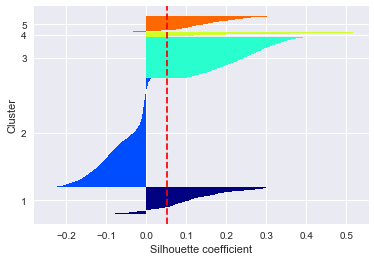

In [55]:
#we already know the average silhouette coefficient, and here we'd like to see the details with the best k.
silhouette_vals = silhouette_samples(data, labels, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
    c_silhouette_vals,
    height=1.0,
    edgecolor='none',
    color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

## PCA and Clustering

From the above model building process, I realize that the speed is relatively slow. We can use PCA to reduce dimensions and thus make our model simpler.

In [57]:
#Use PCA to reduce the number of variables, thus reducing the complexity of our model.
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
df_pca = pca.fit_transform(df)
ratio = pca.explained_variance_ratio_

#decide how many components we should choose
#here we choose 10
ratio_running = np.array(ratio.cumsum())
ratio_running

array([ 0.10445512,  0.1949566 ,  0.24891813,  0.29323324,  0.33336167,
        0.36621044,  0.39505425,  0.41916585,  0.44086312,  0.46191673,
        0.4818821 ,  0.50111186,  0.51809208,  0.53299055,  0.54718662,
        0.56056825,  0.57351234,  0.58604089,  0.59814102,  0.61014072,
        0.62175063,  0.63328141,  0.64465748,  0.65584263,  0.66685784,
        0.67696735,  0.68701027,  0.69656534,  0.70578405,  0.71474152,
        0.72360055,  0.73208335,  0.74047306,  0.74875179,  0.75666262,
        0.76451774,  0.77199237,  0.77936261,  0.78647735,  0.79350526,
        0.80010006,  0.8063199 ,  0.81212579,  0.81771494,  0.82291047,
        0.82787339,  0.83272356,  0.83748346,  0.84197858,  0.8462564 ,
        0.85051697,  0.85470645,  0.85884704,  0.86289139,  0.86681967,
        0.8707138 ,  0.8745689 ,  0.87837052,  0.88211927,  0.88571216,
        0.88918953,  0.89246263,  0.89559264,  0.89861055,  0.90152875,
        0.90435324,  0.90709298,  0.90980044,  0.91247139,  0.91

From the result above, we can see that the first half of components retain over 90% of the variance, and this means we can reduce the number of variables to a half if we can accept 90% variance.

In [64]:
# However, we can denote the tolerance directly in the PCA so that we do not need to check the list above anymore.
pca = PCA(.90)
df_pca = pca.fit_transform(df)

In [ ]:
#Then we can run same code of clustering

In [65]:
#run the clustering
from sklearn.cluster import KMeans
data = df_pca
km = KMeans(n_clusters = 5, init= 'k-means++',max_iter = 300, random_state = 1, n_init = 10, tol = 1e-04)
y_km = km.fit_predict(data)

In [66]:
from sklearn import metrics
metrics.silhouette_score(data, y_km, metric='euclidean')

0.071287934199772834

In [69]:
#use elbow method to find the best n_clusters
distortions_pca = []
silhouette_score_pca = []
for i in range(2,31):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=1)
    label = km.fit_predict(data)
    distortions_pca.append(km.inertia_)
    sc = metrics.silhouette_score(data, label)
    silhouette_score_pca.append(sc)
    


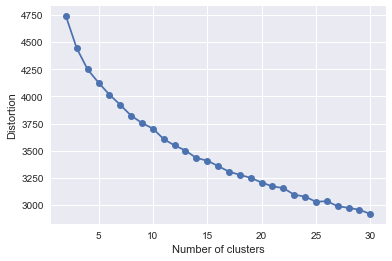

In [70]:
plt.plot(range(2,31), distortions_pca, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

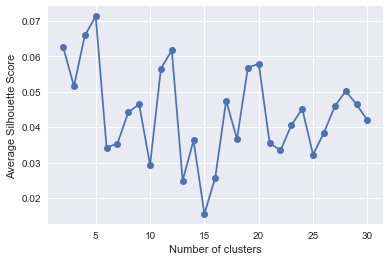

In [71]:
plt.plot(range(2,31), silhouette_score_pca, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

From above picture, we can see that 5 is good number of clusters. Then let's see the details of Silhouette Score when k = 5.

In [72]:
##then let's see the performance of clustering
from matplotlib import cm
import numpy as np
from sklearn.metrics import silhouette_samples

In [73]:
#Notice: here we need to run the k-means with best k again.
kmeans = KMeans(n_clusters=5, init='k-means++',n_init=10,max_iter=300, tol=1e-04, random_state=1)
kmeans.fit(data)
labels = kmeans.labels_

cluster_labels = np.unique(labels)
n_clusters = cluster_labels.shape[0]

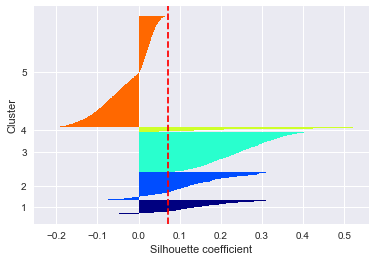

In [74]:
#we already know the average silhouette coefficient, and here we'd like to see the details with the best k.
silhouette_vals = silhouette_samples(data, labels, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
    c_silhouette_vals,
    height=1.0,
    edgecolor='none',
    color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

We can see that the graph of Silhouette coefficient with PCA is quite similar to that without PCA, despite the color and the order.

## Interpretation of Clusters

We now have clusters for each customer, but what does the clusters mean in business? What is the preference for each cluster? 

In [76]:
# get the labels from Clustering with PCA
df["cluster"] = labels

In [88]:
# get the mean percentage of each aisle for each cluster
df_c = df.groupby(["cluster"]).mean()
df_c.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000105,0.002937,0.000179,0.000223,0.009549,0.000509,0.005322,0.000359,0.000091,0.000947,...,0.008801,0.006127,0.002362,0.003059,0.001037,0.000921,0.000966,0.023545,0.000167,0.299942
1,0.000266,0.002624,0.000129,0.000090,0.005196,0.000420,0.006029,0.000305,0.000168,0.000650,...,0.006856,0.005128,0.002301,0.002394,0.001293,0.000394,0.001137,0.019037,0.000387,0.023739
2,0.000161,0.005974,0.000046,0.000171,0.005041,0.000648,0.007455,0.000304,0.000105,0.000393,...,0.005852,0.003607,0.004978,0.004879,0.000306,0.000524,0.001150,0.016038,0.000204,0.021741
3,0.000260,0.001488,0.000260,0.000000,0.001106,0.002137,0.005664,0.000000,0.000000,0.002466,...,0.005154,0.008184,0.000519,0.002510,0.001849,0.001645,0.000909,0.579874,0.000312,0.008065
4,0.001127,0.005601,0.000349,0.000362,0.011259,0.002492,0.013240,0.000975,0.000307,0.004734,...,0.011383,0.010253,0.003336,0.005787,0.002190,0.001972,0.002276,0.022718,0.002486,0.019914


In [83]:
# get the top 10 aisles for cluster 1
df_c.loc[1,:].sort_values(ascending=False).head(10)

aisle
fresh fruits                     0.381116
packaged vegetables fruits       0.060886
fresh vegetables                 0.049772
milk                             0.032325
packaged produce                 0.027102
yogurt                           0.023739
soy lactosefree                  0.019838
packaged cheese                  0.019516
water seltzer sparkling water    0.019037
bread                            0.015866
Name: 1, dtype: float64

In [87]:
# run a for loop to see top 10 aisles for each cluster
for i in np.unique(labels):
    print("###########################################################################")
    print("Top Ten Aisles" + " of Cluster " + str(i))
    print(df_c.loc[i,:].sort_values(ascending=False).head(10))
    

###########################################################################
Top Ten Aisles of Cluster 0
aisle
yogurt                           0.299942
fresh fruits                     0.086316
fresh vegetables                 0.039678
milk                             0.038157
packaged vegetables fruits       0.035814
water seltzer sparkling water    0.023545
packaged cheese                  0.023133
soy lactosefree                  0.019909
bread                            0.016770
chips pretzels                   0.016609
Name: 0, dtype: float64
###########################################################################
Top Ten Aisles of Cluster 1
aisle
fresh fruits                     0.381116
packaged vegetables fruits       0.060886
fresh vegetables                 0.049772
milk                             0.032325
packaged produce                 0.027102
yogurt                           0.023739
soy lactosefree                  0.019838
packaged cheese                  0.019516


What insights could we find from the above cell?

1. Different clusters have different preferences. Cluster 0 prefer yogurt, cluster  1 love fresh fruits, closter 2 like fresh vegetables, and cluster 3 adore water!
2. The cluster 4 might not have a clear preference.

However, you might find that the top 10 goods for each clusters are really similar, althouth they are in different orders. This is because some goods are necessaries of life such as cheese, water and fruits. What if we want to know the special preference of each cluster?

In [94]:
# There are many methods to demonstrate the special preference. Here, I calculate the mean of each aisle for all clusters.
# Then divide the number of each cell by the mean.
df_p = df_c/df_c.mean().values
df_p.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.272557,0.788565,0.930520,1.318842,1.485052,0.410146,0.705687,0.922749,0.678557,0.515180,...,1.156647,0.919984,0.875053,0.821116,0.777052,0.844156,0.750483,0.178044,0.235108,4.016351
1,0.693860,0.704400,0.670460,0.532635,0.808041,0.338189,0.799397,0.784367,1.251451,0.353672,...,0.900954,0.769950,0.852563,0.642499,0.968808,0.361278,0.882898,0.143954,0.544776,0.317873
2,0.418812,1.603935,0.237447,1.009545,0.783989,0.522387,0.988453,0.783252,0.781105,0.213654,...,0.769118,0.541694,1.844179,1.309603,0.229037,0.480240,0.892982,0.121279,0.287059,0.291127
3,0.676915,0.399511,1.347525,0.000000,0.172023,1.721726,0.750949,0.000000,0.000000,1.341862,...,0.677307,1.228857,0.192357,0.673564,1.384562,1.507359,0.705719,4.384934,0.438013,0.107989
4,2.937856,1.503588,1.814048,2.138979,1.750895,2.007552,1.755515,2.509632,2.288887,2.575633,...,1.495974,1.539516,1.235848,1.553218,1.640540,1.806968,1.767918,0.171789,3.495043,0.266660


In [95]:
# run a for loop to see top 10 special aisles for each cluster
for i in np.unique(labels):
    print("###########################################################################")
    print("Top Ten Special Aisles" + " of Cluster " + str(i))
    print(df_p.loc[i,:].sort_values(ascending=False).head(10))

###########################################################################
Top Ten Special Aisles of Cluster 0
aisle
yogurt                           4.016351
granola                          2.307627
feminine care                    1.943254
frozen breakfast                 1.586739
baby food formula                1.485052
canned fruit applesauce          1.484314
hot cereal pancake mixes         1.430359
cereal                           1.392670
refrigerated pudding desserts    1.374711
milk                             1.342616
Name: 0, dtype: float64
###########################################################################
Top Ten Special Aisles of Cluster 1
aisle
fresh fruits                    2.904060
packaged produce                2.130241
seafood counter                 1.554728
packaged vegetables fruits      1.326089
bulk grains rice dried goods    1.296641
beauty                          1.251451
nuts seeds dried fruit          1.165542
frozen produce                  1

The result now looks totally different right? Because we remove the influence of "necessaries", now we can dig the true characteristcs of each cluster.

1. Cluster 0 might be young ladies, because they pruchase yogurt, granola and feminie care far more than the average purchase rate.
2. Cluster 1 might like packaged produce and seafood.
3. Cluster 2 might be Indian, since they buy herbs and indian foods.
4. Cluster 3 might have dogs.
5. Cluster 4 might love drinks.

Definately you can get your own perspectives from that result, but anyway, it is really interesting to portrait our customers, right?